# MAP553 Kaggle challenge - Forest cover type
---
author : Rémi Grzeczkowicz

mail : [remi.grzeczkowicz@polytechnique.edu](mailto:remi.grzeczkowicz@polytechnique.edu)

## Table of contents

1. [Introduction](#intro)
2. [Import libraries](#import)
3. [Data exploration](#explore)
    3.1. [Features spread](#spread)
    3.2. [Categorical distribution](#cat)
        3.2.1. [Cover type](#cover)
        3.2.2. [Wilderness area](#wild)
        3.2.3. [Soil type](#soil)
    3.3. [Correlation with cover type](#corr)
4. [Data preprocessing](#preprocess)
    4.1. [Removing useless features](#useless)
        4.1.1. [Feature importance](#importance)
        4.1.2. [Features selection](#selection)
    4.2. [Removing outliers](#outliers)
    4.3. [Scaling from 0 to 1](#scale)
    4.4. [Train test split](#split)
5. [Model selection](#model)
    5.1. [KNN](#knn)
    5.2. [Random Forest](#rf)
    5.3. [Gradient Boosting](#gb)
    5.4. [AdaBoost](#ada)
    5.5. [Extra Trees](#extra)
    5.6. [XGBoost](#xgb)
    5.7. [LightGBM](#lgbm)
    5.8. [Logistic Regression](#logreg)
    5.9. [Multi-class SVM](#svm)
    5.10. [Final model](#final)
6. [Submission](#submit)
7. [Conclusion](#conclusion)

    



---
## 1. Introduction <a name="intro"></a>
The aim of the challenge is to predict the forest cover type. 

In [1]:
### Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys 
import os
import sklearn
from sklearn.metrics import accuracy_score


In [2]:
print('Python: {}'.format(sys.version))  # Python version
print('numpy: {}'.format(np.__version__))  # Numpy version
print('pandas: {}'.format(pd.__version__))  # Pandas version
print('seaborn: {}'.format(sns.__version__))  # seaborn version
print('sklearn: {}'.format(sklearn.__version__))  # sklearn version

Python: 3.11.7 (main, Dec  4 2023, 18:10:11) [Clang 15.0.0 (clang-1500.1.0.2.5)]
numpy: 1.26.2
pandas: 1.5.3
seaborn: 0.13.0
sklearn: 1.3.2


In [3]:
# Removing warnings
import warnings
warnings.filterwarnings('ignore')


In [4]:
### Generate the submission file
def generating_submission_csv(prediction, name=""):
    data = {'Id': [k+1 for k in range(len(prediction))], 'Cover_type': prediction}

    # Create DataFrame from dictionary
    predictions_df = pd.DataFrame(data)

    # Save to csv
    predictions_df.to_csv('predictions_'+name+'.csv', index=False)

---
## 2. Import data <a name="import"></a>

In [5]:
train_data = pd.read_csv('data/train.csv')
test_data = pd.read_csv('data/test-full.csv')

In [6]:
train_data.head()

,Id,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,...,Soil_Type32,Soil_Type33,Soil_Type34,Soil_Type35,Soil_Type36,Soil_Type37,Soil_Type38,Soil_Type39,Soil_Type40,Cover_Type
0,242642,2881,130,22,210,54,1020,250,221,88,...,0,0,0,0,0,0,0,0,0,1
1,309891,3005,351,14,242,-16,1371,194,215,159,...,0,0,0,0,0,0,0,0,0,1
2,287847,3226,63,14,618,2,1092,232,210,107,...,0,0,0,0,0,0,0,0,0,1
3,516307,3298,317,8,661,60,752,198,233,174,...,0,0,0,0,0,0,0,0,0,1
4,124860,3080,35,6,175,26,3705,219,227,144,...,0,0,0,0,0,0,0,0,0,1


In [7]:
shape = train_data.shape
print("The train dataset contains {} rows and {} columns.".format(shape[0], shape[1]))

The train dataset contains 15120 rows and 56 columns.


In [8]:
shape = test_data.shape
print("The test dataset contains {} rows and {} columns.".format(shape[0], shape[1]))

The test dataset contains 581012 rows and 55 columns.


In [9]:
# Remove the Id column and cover type column
id_train = train_data['Id']
cover_type_train = train_data['Cover_Type']
id_test = test_data['Id']
train_data.drop(['Id', 'Cover_Type'], axis=1, inplace=True)
test_data.drop(['Id'], axis=1, inplace=True)

In [10]:
train_numerical_features = train_data.iloc[:, :10]

---
## 3. Data exploration <a name="explore"></a>

### 3.1. Features spread <a name="spread"></a>

Text(0, 0.5, 'Features')

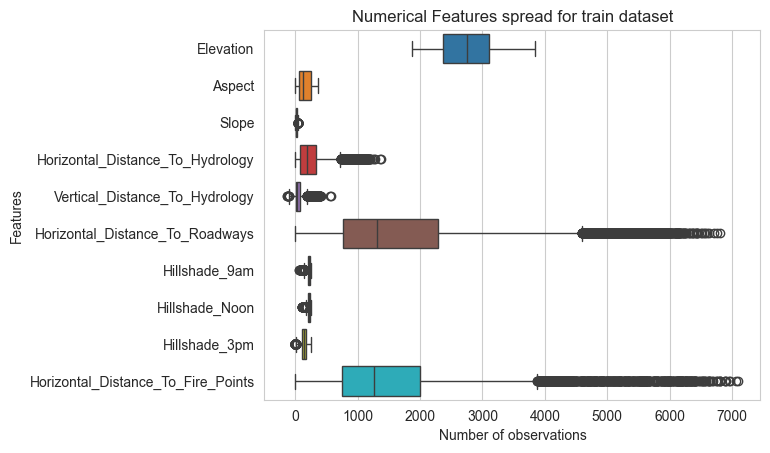

In [11]:
sns.set_style("whitegrid")
sns.boxplot(data = train_numerical_features, orient='h')
plt.title("Numerical Features spread for train dataset")
plt.xlabel("Number of observations")
plt.ylabel("Features")

Text(0, 0.5, 'Features')

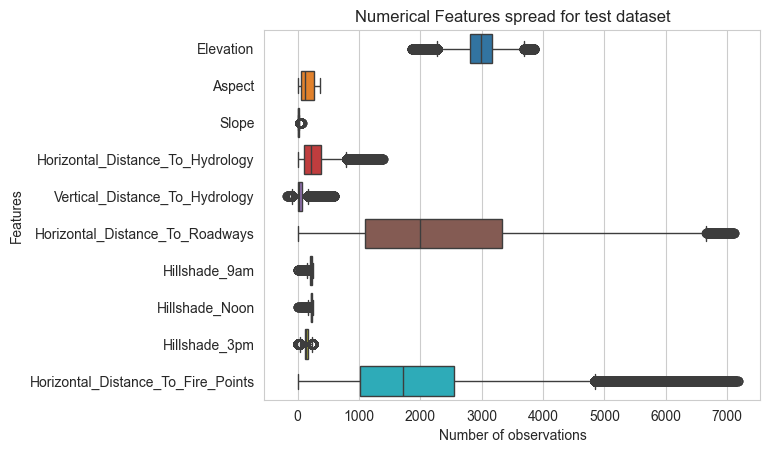

In [12]:
sns.set_style("whitegrid")
sns.boxplot(data = test_data.iloc[:, :10], orient='h')
plt.title("Numerical Features spread for test dataset")
plt.xlabel("Number of observations")
plt.ylabel("Features")

Elevation and aspect are the two features that does not seem to have outliers in train dataset but Elevation has outliers in test dataset. 
Slope is the most squeezed feature for both cases.
Hillshade features without their outliers are quite similar to slope.
All in all, features distribution are quite similar for train and test dataset.

### 3.2. Categorical distribution <a name="cat"></a>

#### 3.2.1. Cover type <a name="cover"></a>

Text(0, 0.5, 'Number of observations')

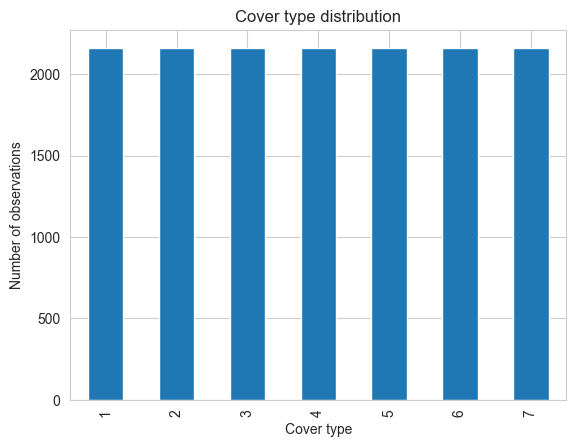

In [13]:
cover_type_train.value_counts().plot(kind='bar', title='Cover type distribution')
plt.xlabel("Cover type")
plt.ylabel("Number of observations")

The dataset is balanced with respect to the cover type. This means we do not have to rebalance it.

#### 3.2.2. Wilderness area <a name="wild"></a>

Text(0, 0.5, 'Number of observations')

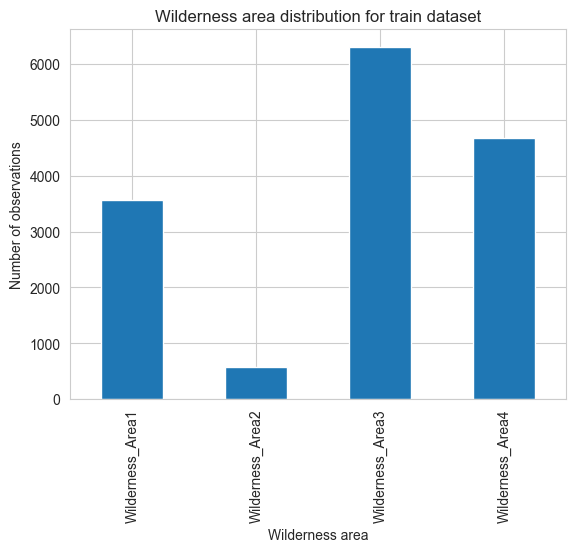

In [14]:
wilderness_area = train_data.iloc[:, 10:14]
wilderness_area.sum().plot(kind='bar')
plt.xlabel("Wilderness area")
plt.title("Wilderness area distribution for train dataset")
plt.ylabel("Number of observations")


Text(0, 0.5, 'Number of observations')

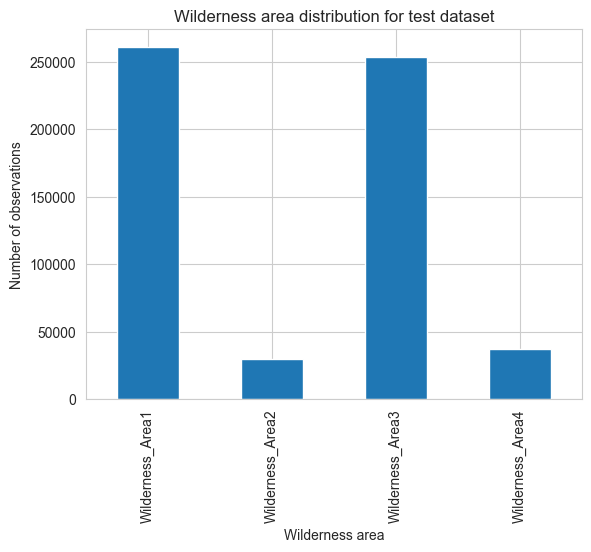

In [15]:
wilderness_area = test_data.iloc[:, 10:14]
wilderness_area.sum().plot(kind='bar')
plt.xlabel("Wilderness area")
plt.title("Wilderness area distribution for test dataset")
plt.ylabel("Number of observations")

Wilderness area is not balanced for both train and test dataset.
Also, wilderness area does not have the same distribution for train and test dataset, especially for wilderness area 4.

#### 3.2.3. Soil type <a name="soil"></a>

Text(0, 0.5, 'Number of observations')

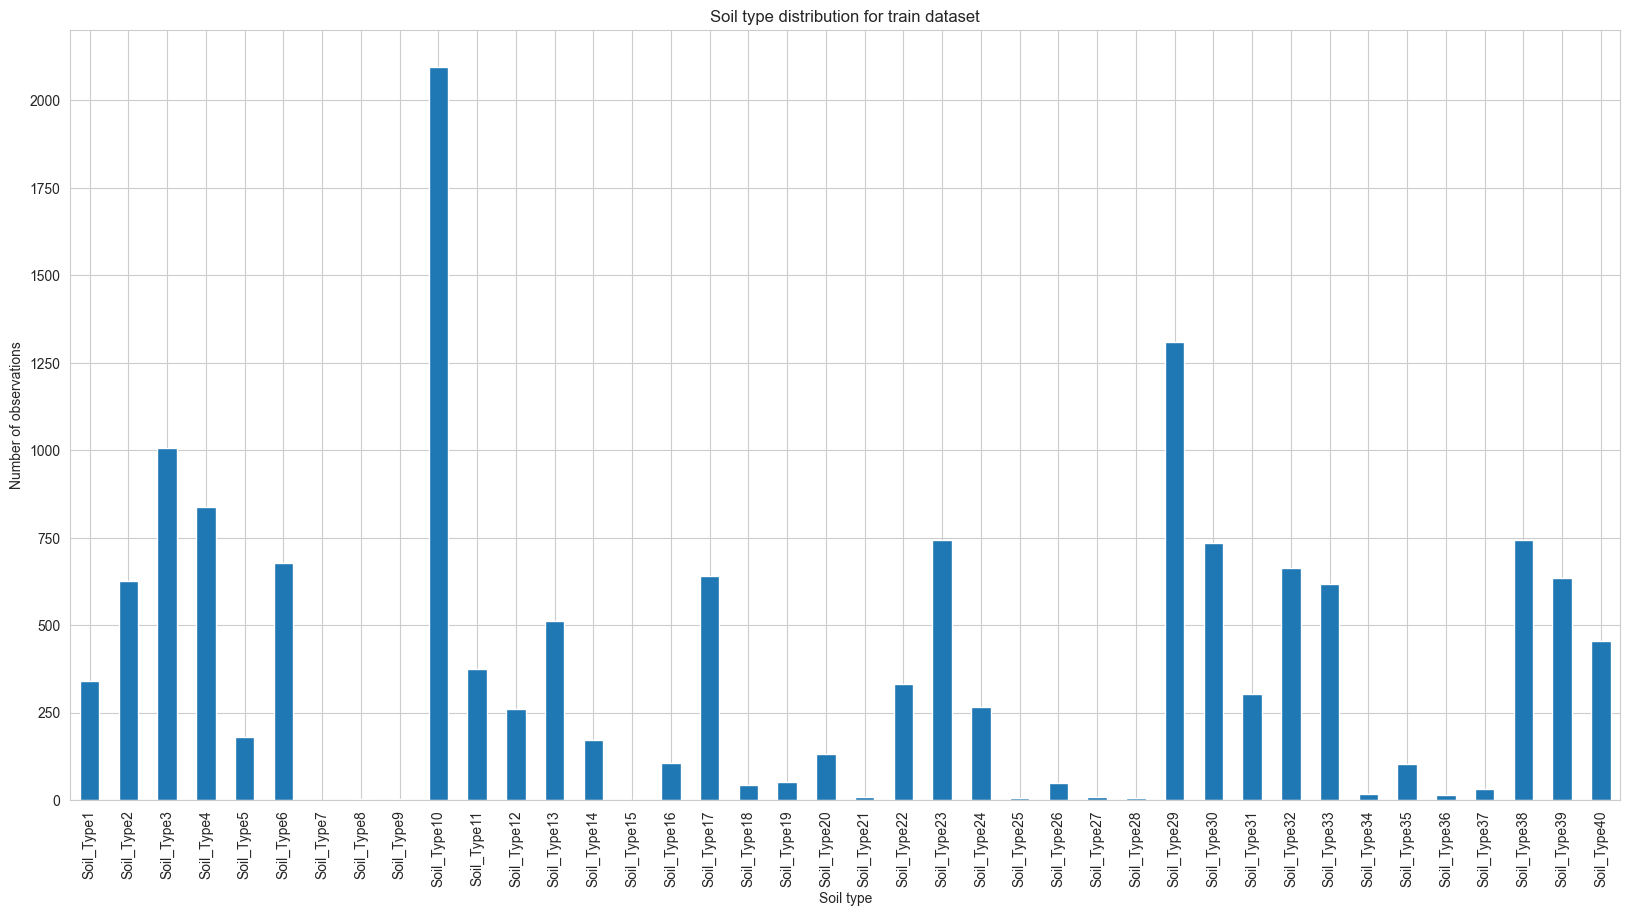

In [16]:
sol_type = train_data.iloc[:, 14:]
sol_type.sum().plot(kind='bar', figsize=(20, 10))
plt.xlabel("Soil type")
plt.title("Soil type distribution for train dataset")
plt.ylabel("Number of observations")

Text(0, 0.5, 'Number of observations')

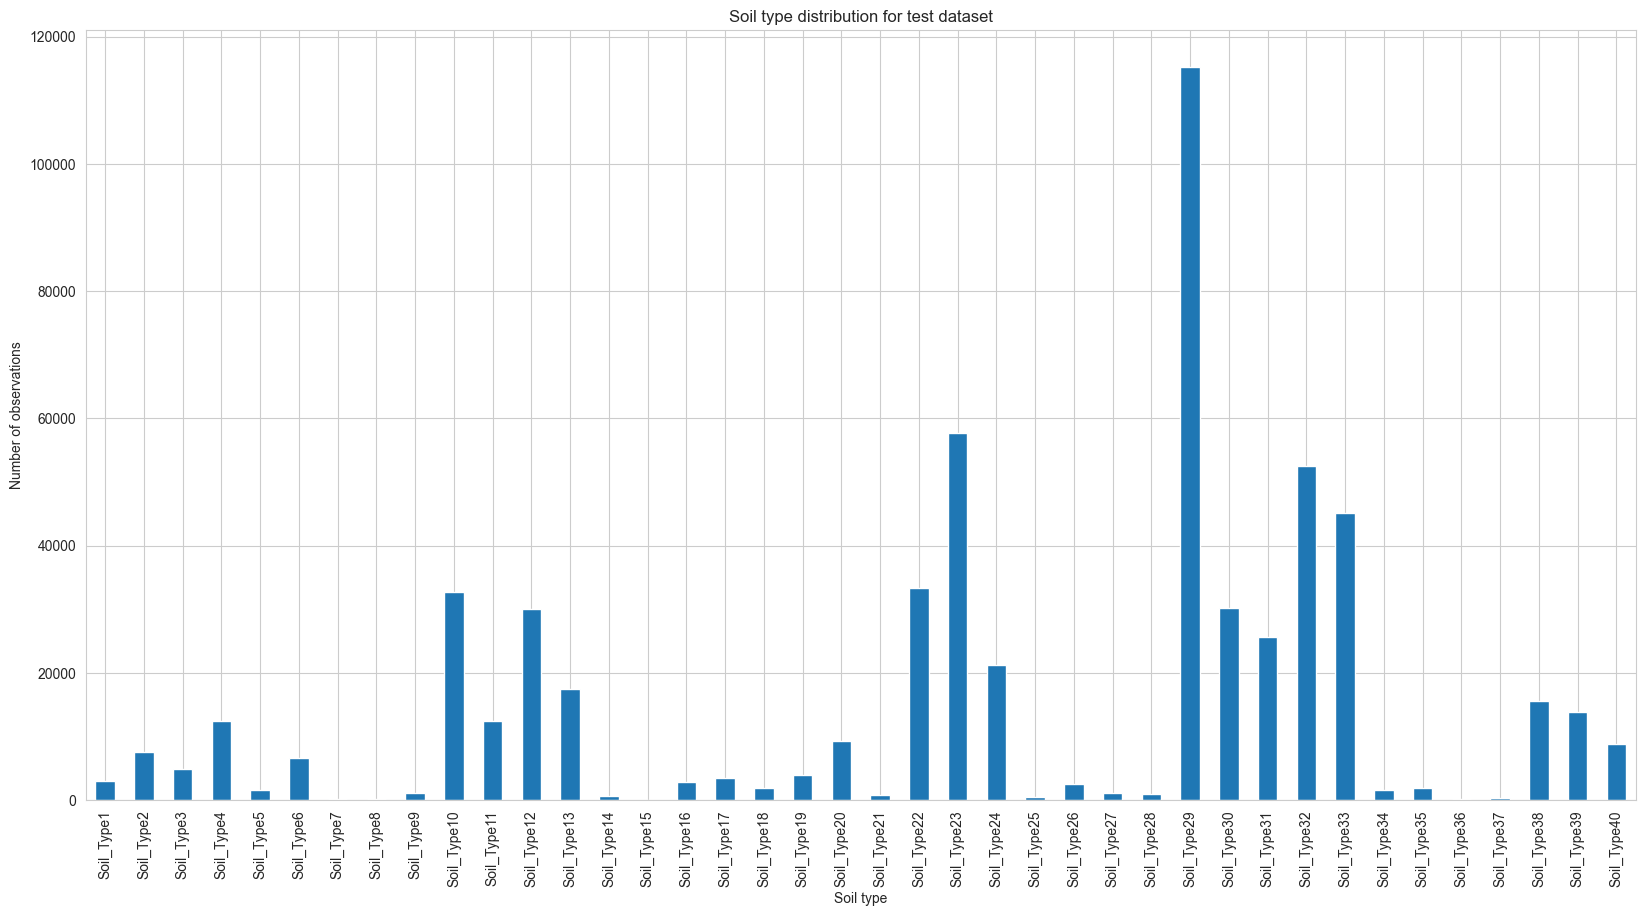

In [17]:
sol_type = test_data.iloc[:, 14:]
sol_type.sum().plot(kind='bar', figsize=(20, 10))
plt.xlabel("Soil type")
plt.title("Soil type distribution for test dataset")
plt.ylabel("Number of observations")

Soil type is absolutely not balanced with high peaks for some soil types and almost no observations for others.
Also soil type distribution is not the same for train and test dataset, with some soil types that are over represented in train dataset compared to test dataset.

NB : we tried to rebalance the training dataset by removing some observations but it did not improve the accuracy of the model.

### 3.3. Correlation with cover type <a name="corr"></a>

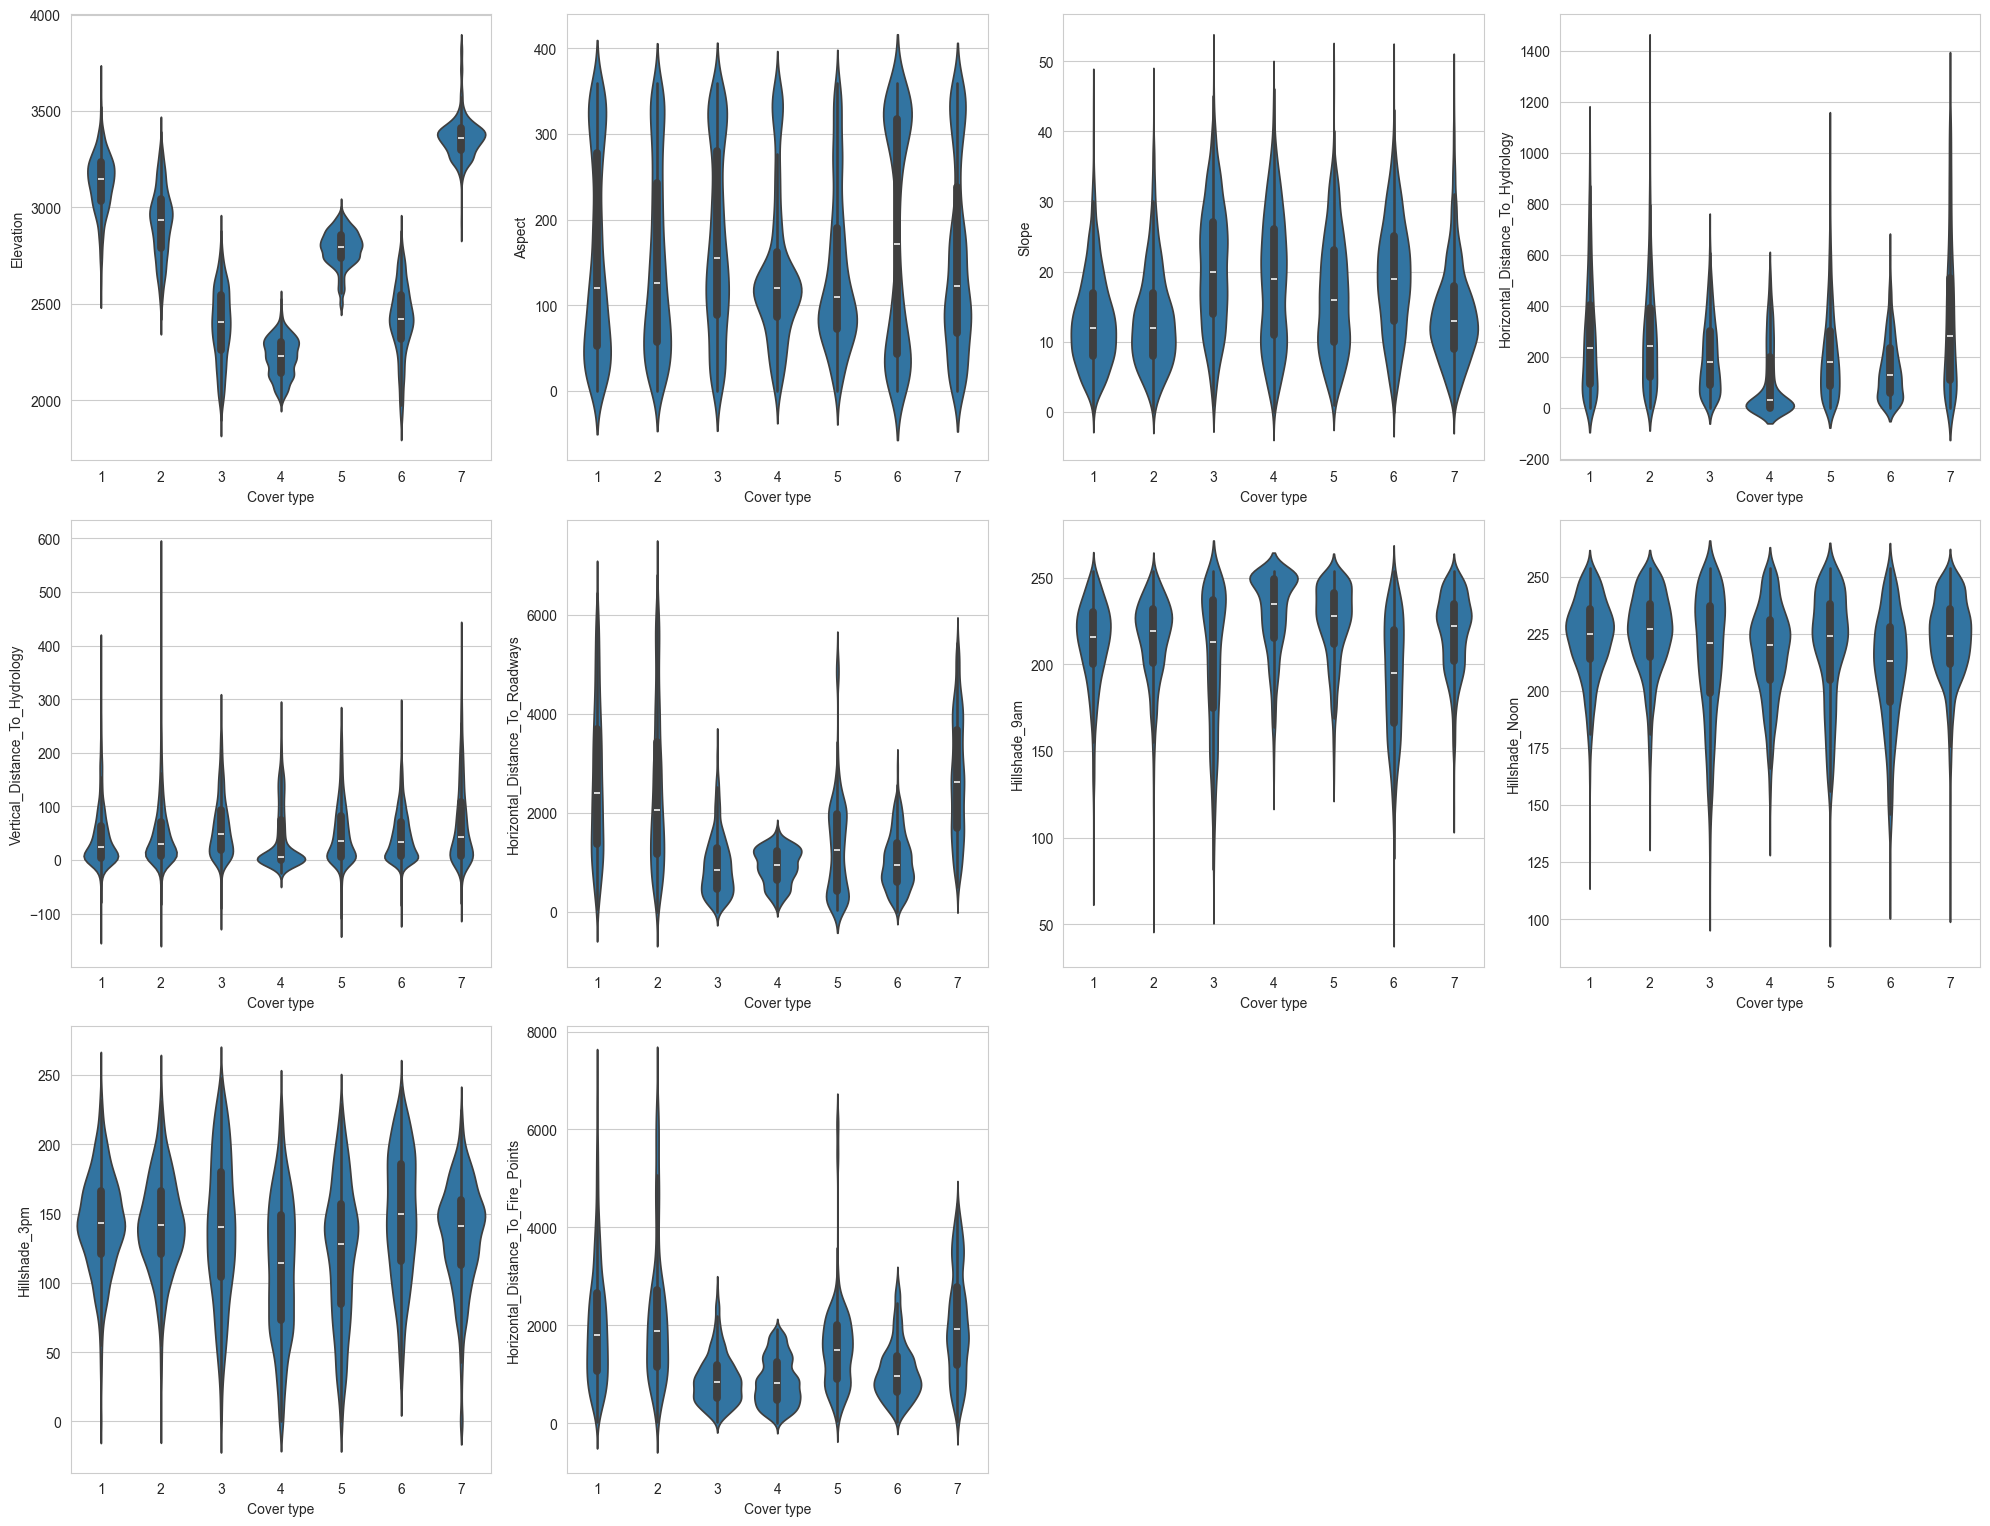

In [18]:
# Let's plot violin plots for each feature with respect to the cover type
plt.figure(figsize=(20, 20))
for i in range(len(train_numerical_features.columns)):
    features = train_numerical_features.columns[i]
    plt.subplot(4, 4, i+1)
    sns.violinplot(x=cover_type_train, y=features, data=train_data)
    plt.xlabel("Cover type")
    plt.ylabel(features)
plt.tight_layout()

This visualisation shows that some features are more correlated with the cover type than others.
For example : the elevation is very different for each cover type where as the vertical distance to hydrology is almost the same for each cover type.
All of this plots shows that selecting all the features will not give the best results.

---
## 4. Data preprocessing <a name="preprocess"></a>

### 4.1. Removing useless features <a name="useless"></a>

#### 4.1.1. Feature importance
Sklearn provides a feature_importance_ attribute for RandomForestClassifier, ExtraTreesClassifier, AdaBoostClassifier and GradientBoostingClassifier. We will use it to select the most important features.

In [19]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(random_state = 42)
model.fit(train_data, cover_type_train)

important_features = pd.DataFrame(model.feature_importances_, index = train_data.columns, columns=['RFC']).sort_values('RFC', ascending=False)

important_features.head(20)

,RFC
Elevation,0.223542
Horizontal_Distance_To_Roadways,0.094263
Horizontal_Distance_To_Fire_Points,0.074507
Horizontal_Distance_To_Hydrology,0.061820
Vertical_Distance_To_Hydrology,0.053246
Hillshade_9am,0.050765
Aspect,0.047537
Hillshade_3pm,0.045444
Hillshade_Noon,0.044717
Wilderness_Area4,0.042976


In [20]:
from sklearn.ensemble import GradientBoostingClassifier

model = GradientBoostingClassifier(random_state = 42)
model.fit(train_data, cover_type_train)

important_features = pd.DataFrame(model.feature_importances_, index = train_data.columns, columns=['GBC']).sort_values('GBC', ascending=False)

important_features.head(20)

,GBC
Elevation,0.585207
Soil_Type10,0.057545
Horizontal_Distance_To_Roadways,0.047660
Horizontal_Distance_To_Hydrology,0.042244
Hillshade_9am,0.039421
Horizontal_Distance_To_Fire_Points,0.039255
Soil_Type30,0.021908
Vertical_Distance_To_Hydrology,0.020111
Soil_Type4,0.016131
Soil_Type12,0.014350


In [21]:
from sklearn.ensemble import AdaBoostClassifier

model = AdaBoostClassifier(random_state = 42)
model.fit(train_data, cover_type_train)

important_features = pd.DataFrame(model.feature_importances_, index = train_data.columns, columns=['ADB']).sort_values('ADB', ascending=False)

important_features.head(20)

,ADB
Wilderness_Area4,0.46
Elevation,0.30
Horizontal_Distance_To_Fire_Points,0.08
Vertical_Distance_To_Hydrology,0.06
Aspect,0.04
Horizontal_Distance_To_Hydrology,0.02
Slope,0.02
Soil_Type4,0.02
Soil_Type20,0.00
Soil_Type21,0.00


In [22]:
from sklearn.ensemble import ExtraTreesClassifier

model = ExtraTreesClassifier(random_state = 42)
model.fit(train_data, cover_type_train)

important_features = pd.DataFrame(model.feature_importances_, index = train_data.columns, columns=['ETC']).sort_values('ETC', ascending=False)

important_features.head(20)

,ETC
Elevation,0.166172
Horizontal_Distance_To_Roadways,0.081416
Horizontal_Distance_To_Fire_Points,0.067628
Horizontal_Distance_To_Hydrology,0.058656
Wilderness_Area4,0.052043
Vertical_Distance_To_Hydrology,0.049678
Aspect,0.049159
Hillshade_9am,0.048314
Hillshade_3pm,0.045403
Hillshade_Noon,0.045079


#### 4.1.2. Features selection

Now that we have the feature importance for different model, we can select the most important features.
Paper Suhail, S. J., & Refonaa, J. (2023, April). Forest Cover Type Classification Using Machine Learning Algorithms. In 2023 International Conference on Distributed Computing and Electrical Circuits and Electronics (ICDCECE) (pp. 1-5). IEEE. suggests to select the 25 most important features.

So according to our results, we will select the following features :
| Number | Feature |
| --- | --- |
| 1 | Elevation |
| 2 | Horizontal distance to fire Points |
| 3 | Horizontal distance to Hydrology |
| 4 | Vertical distance to Hydrology |
| 5 | Wilderness Area 4 |
| 6 |Aspect |
| 7 | Soil_Type4 |
| 8 | Slope |
| 9 | Horizontal_Distance_To_Roadways |
| 10 | Hillshade_9am |
| 11 | Soil_Type10 |
| 12 | Hillshade_Noon |
| 13 | Hillshade_3pm |
| 14 | Soil_Type3 |
| 15 | Wilderness_Area3 |
| 16 | Soil_Type30 |
| 17 | Soil_Type39 |
| 18 | Wilderness_Area1 |
| 19 | Soil_Type12 |
| 20 | Soil_Type38 |
| 21 | Soil_Type2 |
| 22 | Soil_Type13 |
| 23 | Soil_Type17 |
| 24 | Soil_Type29 |
| 25 | Soil_Type40 |

In [23]:
selected_features = ['Elevation', 'Horizontal_Distance_To_Fire_Points', 'Horizontal_Distance_To_Hydrology', 'Vertical_Distance_To_Hydrology', 'Wilderness_Area4', 'Aspect', 'Soil_Type4', 'Slope', 'Horizontal_Distance_To_Roadways', 'Hillshade_9am', 'Soil_Type10', 'Hillshade_Noon', 'Hillshade_3pm', 'Soil_Type3', 'Wilderness_Area3', 'Soil_Type30', 'Soil_Type39', 'Wilderness_Area1', 'Soil_Type12', 'Soil_Type38', 'Soil_Type2', 'Soil_Type13', 'Soil_Type17', 'Soil_Type29', 'Soil_Type40']

## 4.2. Removing outliers <a name="outliers"></a>
As we saw before, some numerical features have outliers. We will remove them.

In [24]:
for i in range(10):
    q1 = np.percentile(train_data.iloc[:, i], 25)
    q3 = np.percentile(train_data.iloc[:, i], 75)
    iqr = q3 - q1
    
    # Getting indexes of outliers
    indexes = train_data[(train_data.iloc[:, i] < q1 - 1.5 * iqr) | (train_data.iloc[:, i] > q3 + 1.5 * iqr)].index
    
    # Removing outliers
    train_data.drop(indexes, inplace=True)
    cover_type_train.drop(indexes, inplace=True)
    
print("Number of observations after removing outliers : {}".format(train_data.shape[0]))

Number of observations after removing outliers : 12114


### 4.3. Scaling from 0 to 1 <a name="scale"></a>
It is important to scale the data for model like KNN because they rely on euclidean distance.

In [25]:
for i in range(10):
    min = np.min([train_data.iloc[:, i].min(), test_data.iloc[:, i].min()])
    max = np.max([train_data.iloc[:, i].max(), test_data.iloc[:, i].max()])
    
    train_data.iloc[:, i] = (train_data.iloc[:, i] - min) / (max - min)
    test_data.iloc[:, i] = (test_data.iloc[:, i] - min) / (max - min)


### 4.5. Train test split <a name="split"></a>

In [26]:
from sklearn.model_selection import train_test_split
#With full features
X_train, X_test, y_train, y_test = train_test_split(train_data[selected_features], cover_type_train, test_size=0.2, random_state=42)
X_train.head()

,Elevation,Horizontal_Distance_To_Fire_Points,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Wilderness_Area4,Aspect,Soil_Type4,Slope,Horizontal_Distance_To_Roadways,Hillshade_9am,...,Soil_Type30,Soil_Type39,Wilderness_Area1,Soil_Type12,Soil_Type38,Soil_Type2,Soil_Type13,Soil_Type17,Soil_Type29,Soil_Type40
2611,0.764382,0.108741,0.215462,0.254522,0,0.138889,0,0.121212,0.098075,0.881890,...,0,0,0,0,0,0,0,0,0,1
441,0.641821,0.172452,0.088762,0.223514,0,0.900000,0,0.151515,0.510889,0.767717,...,0,0,1,0,0,0,0,0,0,0
143,0.545273,0.181514,0.416607,0.452196,0,0.986111,0,0.212121,0.090488,0.775591,...,0,0,0,0,0,0,0,0,0,0
7342,0.201101,0.053534,0.021475,0.227390,1,0.461111,0,0.212121,0.045525,0.909449,...,0,0,0,0,0,0,0,0,0,0
8655,0.386693,0.103443,0.171797,0.214470,0,0.955556,0,0.045455,0.134888,0.838583,...,0,0,0,0,0,0,0,1,0,0


## 5. Model selection <a name="model"></a>
Here we will try different models and select the best one.

In [27]:
# This function will be used to evaluate the models
from sklearn.model_selection import cross_val_score
def evaluate_model(classifier, verbose=True):
    classifier.fit(X_train, y_train)
    accuracy = cross_val_score(classifier, X_train, y_train, cv=10, scoring='accuracy').mean()
    if verbose:
        print("Accuracy of this model is : {}".format(accuracy))
    else:
        return accuracy

### 5.1. KNN <a name="knn"></a>

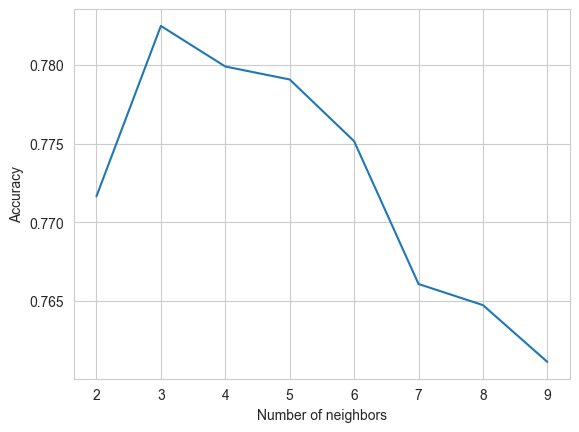

In [28]:
from sklearn.neighbors import KNeighborsClassifier
accuracy = []
for k in range(2, 10):
    classifier = KNeighborsClassifier(n_neighbors=k)
    accuracy.append(evaluate_model(classifier, verbose=False))

plt.xlabel("Number of neighbors")
plt.ylabel("Accuracy")
plt.plot(range(2, 10), accuracy)

In [29]:
classifier = KNeighborsClassifier(n_neighbors=3)
evaluate_model(classifier)

Accuracy of this model is : 0.7824776313129701


In [30]:
y_pred = classifier.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy of this model on the validation sample is : {}".format(accuracy))

Accuracy of this model on the validation sample is : 0.7787866281469253


### 5.2. Random Forest <a name="rf"></a>

In [31]:
from sklearn.ensemble import RandomForestClassifier

classifier = RandomForestClassifier(random_state = 42)
evaluate_model(classifier)

Accuracy of this model is : 0.8495506048322747


In [32]:
# Let's try to tune the hyperparameters
from sklearn.model_selection import GridSearchCV

parameters = {'n_estimators': [100, 200, 300, 400, 500], 'max_depth': [10, 20, 30, 40, 50]}
grid_search = GridSearchCV(estimator = classifier, param_grid = parameters, scoring = 'accuracy', cv = 10, n_jobs = -1)
grid_search.fit(X_train, y_train)
best_accuracy = grid_search.best_score_
best_parameters = grid_search.best_params_

In [33]:
print("Best accuracy : {}".format(best_accuracy))
print("Best parameters : {}".format(best_parameters))

Best accuracy : 0.8541932909897547
Best parameters : {'max_depth': 40, 'n_estimators': 200}


In [34]:
classifier = RandomForestClassifier(n_estimators=200, max_depth=40, random_state = 42)
classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy of this model on the validation sample is : {}".format(accuracy))

Accuracy of this model on the validation sample is : 0.8423442014032192


### 5.3. Gradient Boosting <a name="gb"></a>

In [35]:
from sklearn.ensemble import GradientBoostingClassifier

classifier = GradientBoostingClassifier(random_state = 42)
evaluate_model(classifier)

Accuracy of this model is : 0.7880508122945324


In [36]:
y_pred = classifier.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy of this model on the validation sample is : {}".format(accuracy))

Accuracy of this model on the validation sample is : 0.7816756087494842


### 5.4. AdaBoost <a name="ada"></a>

In [37]:
from sklearn.ensemble import AdaBoostClassifier

classifier = AdaBoostClassifier(random_state = 42)
evaluate_model(classifier)

Accuracy of this model is : 0.4171919185471259


In [38]:
y_pred = classifier.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy of this model on the validation sample is : {}".format(accuracy))

Accuracy of this model on the validation sample is : 0.40486999587288486


### 5.5. Extra Trees <a name="et"></a>

In [39]:
from sklearn.ensemble import ExtraTreesClassifier

classifier = ExtraTreesClassifier(random_state = 42)
evaluate_model(classifier)

Accuracy of this model is : 0.8555354122115476


In [40]:
# Let's try to tune the hyperparameters
from sklearn.model_selection import GridSearchCV

parameters = {'max_depth': [10, 20, 30, 40, 50, None], 'bootstrap': [True, False]}
grid_search = GridSearchCV(estimator = classifier, param_grid = parameters, scoring = 'accuracy', cv = 10, n_jobs = -1)
grid_search.fit(X_train, y_train)
best_accuracy = grid_search.best_score_
best_parameters = grid_search.best_params_

In [41]:
print("Best accuracy : {}".format(best_accuracy))
print("Best parameters : {}".format(best_parameters))

Best accuracy : 0.855947996127371
Best parameters : {'bootstrap': False, 'max_depth': 40}


In [42]:
classifier = ExtraTreesClassifier(max_depth=40, random_state = 42)
classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy of this model on the validation sample is : {}".format(accuracy))

Accuracy of this model on the validation sample is : 0.8448204704911267


### 5.6. XGBoost <a name="xgb"></a>

In [43]:
from xgboost import XGBClassifier

#We need to change cover type to start from 0 for XGBoost
y_train = y_train - 1

classifier = XGBClassifier(random_state = 42)
evaluate_model(classifier)

y_train = y_train + 1

Accuracy of this model is : 0.8424300745800218


In [44]:
y_pred = classifier.predict(X_test) + 1
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy of this model on the validation sample is : {}".format(accuracy))

Accuracy of this model on the validation sample is : 0.8258357408171688


### 5.7. LightGBM <a name="lgbm"></a>

In [45]:
from lightgbm import LGBMClassifier

classifier = LGBMClassifier(random_state = 42, verbose=-1)
evaluate_model(classifier)

Accuracy of this model is : 0.8478995244326706


In [46]:
y_pred = classifier.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy of this model on the validation sample is : {}".format(accuracy))

Accuracy of this model on the validation sample is : 0.8378043747420553


### 5.8 Logistic Regression <a name="lr"></a>

In [47]:
from sklearn.linear_model import LogisticRegression

classifier = LogisticRegression(random_state = 42)
evaluate_model(classifier)

Accuracy of this model is : 0.6559700190439715


In [48]:
y_pred = classifier.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy of this model on the validation sample is : {}".format(accuracy))

Accuracy of this model on the validation sample is : 0.6636401155592241


### 5.9. Multi-class SVM <a name="final"></a>

In [49]:
from sklearn.svm import SVC

classifier = SVC(random_state = 42)
evaluate_model(classifier)

Accuracy of this model is : 0.6950766546444949


In [50]:
y_pred = classifier.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy of this model on the validation sample is : {}".format(accuracy))

Accuracy of this model on the validation sample is : 0.6974824597606273


### 5.10. Final model <a name="final"></a>
Let's compare the accuracy over validation set for all the models we tried.
| Model | Accuracy |
| --- | --- |
| KNN | 0.778 |
| Random Forest | 0.842 |
| Gradient Boosting | 0.781 |
| AdaBoost | 0.404 |
| Extra Trees | 0.844 |
| XGBoost | 0.825 |
| LightGBM | 0.837 |
| Logistic Regression | 0.663 |
| Multi-class SVM | 0.697 |

The best model is Extra Trees with an accuracy of 0.844 on validation set closely followed by Random Forest.

In [51]:
classifier = ExtraTreesClassifier(max_depth=40, random_state = 42)
classifier.fit(train_data[selected_features], cover_type_train)

ExtraTreesClassifier(max_depth=40, random_state=42)

## 6. Prediction <a name="predict"></a>
Now let predict the cover type for the test dataset.

In [52]:
test_data_selected = test_data[selected_features]
prediction = classifier.predict(test_data_selected)
generating_submission_csv(prediction, "final_submission_trees")

## 7. Conclusion <a name="conclusion"></a>
The classification of forest according to their cover type is an important task for the management of the forest. In this notebook we have discussed about the best method do classify them using the provided dataset. We have seen that the best model is the Extra Trees Classifier with an accuracy of 0.84 which is a good result for the prediction of the cover type.